In [1]:
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

In [2]:
import astropy.units as u
from astropy.convolution import convolve, Box1DKernel
from astropy.stats import sigma_clipped_stats
from astropy.timeseries.periodograms.lombscargle.implementations.mle import design_matrix

In [170]:
from scipy.interpolate import interp1d
from scipy.ndimage import percentile_filter

In [4]:
from tqdm import tqdm
def build_model(tpf, lc, cbvs, cadence_mask=None):
    """ Build a model for the pixel level light curve """
    if cadence_mask is None:
        cadence_mask = np.ones(len(lc.time)).astype(bool)

    S = np.diag(lc.flux)
    r, c = tpf.pos_corr1, tpf.pos_corr2
    t = tpf.time - tpf.time.mean()
    A = np.vstack([#lc.normalize().flux, lc.normalize().flux*t,
                    np.ones(len(t)),
                    t, t**2, t**3,
                    r, c, r*c, r*c**2, r**2*c, r**2*c**2, r**2, c**2,
                    cbvs[0], cbvs[1]]).T

    #spline = lk.sffcorrector._get_spline_dm(lc.time, n_knots=int((lc.time[-1] - lc.time[0])//2)).values
#    A = np.hstack([A, spline])
    SA = np.dot(S, A)

    SA = np.hstack([SA, np.atleast_2d(np.ones(len(SA))).T])

    model = np.zeros(tpf.flux.shape)

    for idx in tqdm(range(tpf.shape[1])):
        for jdx in range(tpf.shape[2]):

            f = tpf.flux[:, idx, jdx]
            fe = tpf.flux_err[:, idx, jdx]
            if not np.isfinite(f).any():
                continue
            sigma_f_inv = np.diag(1/fe**2)


            SA_T_dot_sigma_f_inv = (SA[cadence_mask]/fe[cadence_mask, None]**2).T
            sigma_w_inv = np.dot(SA_T_dot_sigma_f_inv, SA[cadence_mask])
            B = np.dot(SA_T_dot_sigma_f_inv, f[cadence_mask])
            w = np.linalg.solve(sigma_w_inv, B)
            model[:, idx, jdx] = np.dot(SA, w)
    return model


In [1180]:
#target_name = 'KIC 12314646'
#target_name = 'KIC 8935655'
target_name = "KIC 10857583"
#target_name = "KIC 8814775"
tpfs = lk.search_targetpixelfile(target_name, mission='Kepler', quarter=np.arange(0, 18)).download_all()

In [1181]:
alc = lk.LightCurveCollection([tpf.to_lightcurve(aperture_mask='all') for tpf in tpfs]).stitch().remove_nans()
P = alc.to_periodogram(minimum_period=1, maximum_period=8)
full_period = P.period_at_max_power.value

In [1182]:
full_period

5.3888272035753975

100%|██████████| 5/5 [00:00<00:00, 98.87it/s]


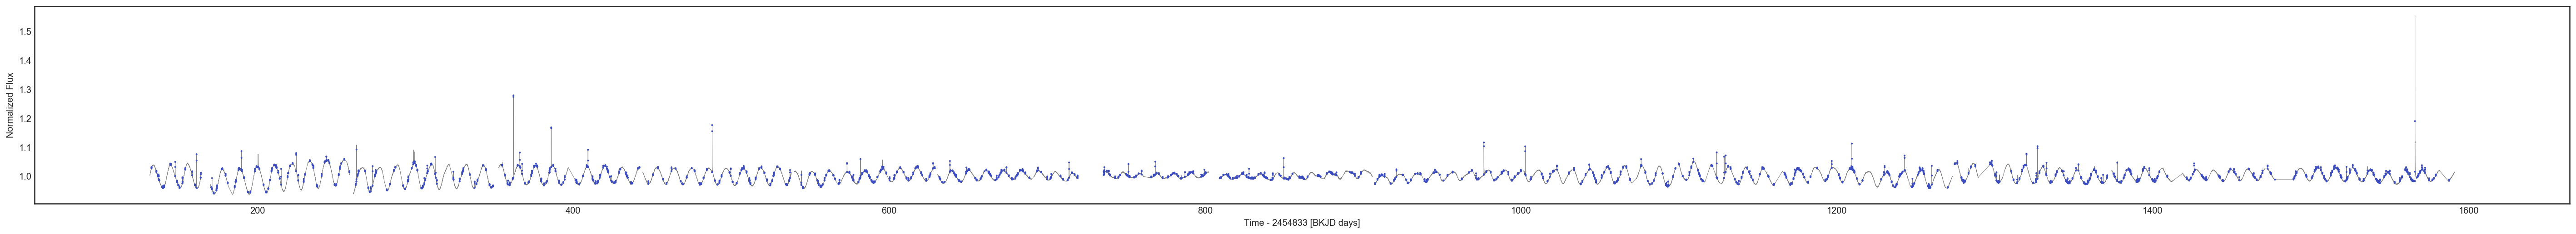

In [1183]:
fig1, ax1 = plt.subplots(figsize=(50, 4))


lcs = []
flcs = []
clcs = []
res = []


fmasks = []
for tpf in tpfs:
    tpf = tpf[(np.nan_to_num(tpf.pos_corr1) > -10) & (np.nan_to_num(tpf.pos_corr1) != 0)]
    tpf = tpf[np.nan_to_num(np.nansum(tpf.flux, axis=(1, 2))) != 0]

    focus_cadences = 20
    focus_changed = tpf.cadenceno[np.where(np.diff(np.append([tpf.cadenceno[0] - 100], tpf.cadenceno)) > 10)[0]]
    focus_changed = np.any([((tpf.cadenceno - f) < focus_cadences) & ((tpf.cadenceno - f) >= 0) for f in focus_changed], axis=0)

    tpf = tpf[~focus_changed]

    lc = tpf.to_lightcurve(aperture_mask='all')

    
    obvious_flares = lc.normalize().flux > 1.5
    obvious_flares |= lc.flatten(41, mask=obvious_flares).remove_outliers(5, return_mask=True)[1]
    obvious_flares |= np.gradient(obvious_flares.astype(int)) < 0
    
    cbvs = lk.KeplerCBVCorrector(lc).cbv_array[:2]


    row = np.polyval(np.polyfit(tpf.time, tpf.pos_corr1, 3), tpf.time)
    column = np.polyval(np.polyfit(tpf.time, tpf.pos_corr2, 3), tpf.time)

    breaks = list(np.where((np.diff(lc.cadenceno)) > 10)[0]-1)
    if breaks == []:
        breaks = None
    r = lc.to_corrector()
    clc = r.correct(row, column, timescale=full_period/4.5, cadence_mask=~obvious_flares,
                    windows=1, breakindex=breaks)
    flc = (r.model_lc + 1)
    bad = (np.gradient(flc.time)/np.nanmedian(np.gradient(flc.time)) > 1.5)
    bad |= np.abs(np.gradient(bad.astype(float))) != 0

    flc.flux[bad] = np.nan
    
        
    any_flares = clc.remove_outliers(sigma=3, return_mask=True)[1]
    model = build_model(tpf, lc, cbvs, cadence_mask=~any_flares)
    aper = tpf.create_threshold_mask(0.5)
    residuals = np.nansum(((tpf.flux - model)**2/tpf.flux_err)[:, aper], axis=1)/aper.sum()
    
    
    _, med, std = sigma_clipped_stats(residuals[~any_flares])
    residuals = (residuals - med)/std
    
    _, med_lc, std_lc = sigma_clipped_stats(clc.flux[~any_flares])
    mask = convolve((residuals > 2) & ((clc.flux - med_lc) > std_lc*3), Box1DKernel(3)) > 0
    mask |= convolve(((clc.flux - med_lc) > std_lc*4), Box1DKernel(3)) > 0


    lc.normalize().plot(ax=ax1, c='grey', zorder=-10, lw=0.5, label='')
    
    fl = np.where(np.diff(mask.astype(float)) == 1)[0] + 1    
    fmask = np.zeros(len(lc.flux)).astype(bool)

    for idx, fl1 in enumerate(fl):
        k = np.in1d(np.arange(len(lc)), np.arange(fl1-1, fl1 + 3)) & ((clc.flux  - 1)> -clc.flux.std())
        ff = clc[k].flux
        fmask[np.where(k)[0][np.argmax(ff)]] = True

        
        ax1.scatter(lc[k].time, lc.normalize()[k].flux, c=np.ones(k.sum()) * residuals[fl1], s=1, vmin=89.5, vmax=90, cmap='coolwarm')
    fmasks.append(fmask)

    lcs.append(lc)
    flcs.append(flc)
    clcs.append(clc)
    res.append(residuals)
#    break


In [1184]:
all_lc = lcs[0].normalize().copy()
_ = [all_lc.append(lc1.normalize(), inplace=True) for lc1 in lcs[1:]]

all_clc = clcs[0].normalize().copy()
_ = [all_clc.append(clc1.normalize(), inplace=True) for clc1 in clcs[1:]]

residuals = np.hstack(res)

/Users/ch/K2/repos/lightkurve/lightkurve/lightcurve.py:675: LightkurveWarning: The light curve already appears to be in relative units; `normalize()` will convert the light curve into relative units for a second time, which is probably not what you want.
  LightkurveWarning)


/Users/ch/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/Users/ch/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app
/Users/ch/miniconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:675: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]
/Users/ch/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/Users/ch/miniconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:675: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]
/Users/ch/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
/Users/ch/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encou

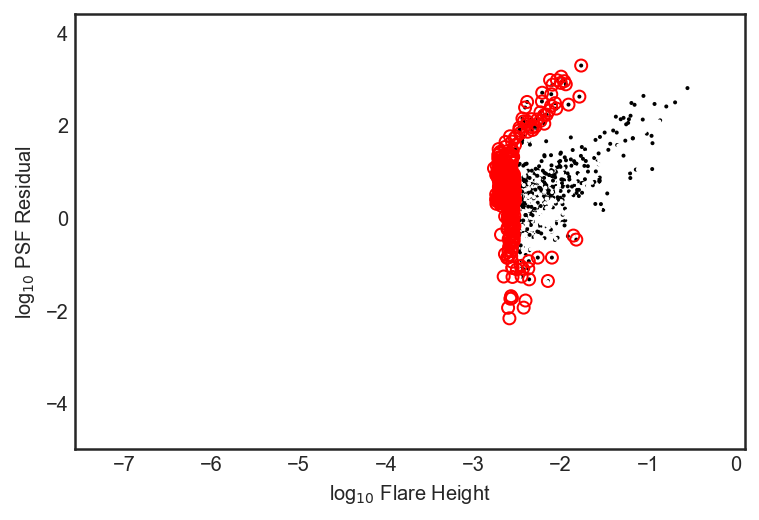

In [1185]:
bad = (np.gradient(all_lc.time)/np.nanmedian(np.gradient(all_lc.time)) > 1.5)
bad |= np.abs(np.gradient(bad.astype(float))) != 0

flare_f = all_clc.flux - 1


#flares = np.hstack(fmasks) & ~bad


tiny = (flare_f) < 0.003

flares = np.hstack(fmasks) & ~bad


x, y = np.log10(flare_f), np.log10(residuals)
k = np.isfinite(x) & np.isfinite(y) & flares & ~tiny

line = np.polyval(np.polyfit(x[k], y[k], 2), x)

k &= (np.abs(y - line) < sigma_clipped_stats(y - line)[2] * 3)
line = np.polyval(np.polyfit(x[k], y[k], 2), x)

cosmic = ((y - line) > sigma_clipped_stats(y - line)[2] * 2)
low_balls = ((y - line) < sigma_clipped_stats(y - line)[2] * -2)


plt.scatter(x, y, s=1, c=k)
plt.scatter(x[(cosmic | tiny | low_balls) & flares], y[(cosmic | tiny | low_balls) & flares], facecolor='None', edgecolor='r')

plt.ylabel('log$_{10}$ PSF Residual')
plt.xlabel('log$_{10}$ Flare Height')

flares = np.hstack(fmasks) & ~bad & ~tiny & ~cosmic &~low_balls


In [1186]:
# t, m, f, df, flare_f = np.hstack(ts), np.hstack(ms), np.hstack(fs), np.hstack(dfs), np.hstack(flare_fs)
# quarter = np.hstack([np.ones(len(t1)) * (lc.quarter) for t1, lc in zip(ts, lcs)])


# k = (df < 0.15) & (df > -0.15)
# t, m, f, df, flare_f = t[k], m[k], f[k], df[k], flare_f[k]
# quarter = quarter[k]
# angle =  np.arctan2(df/df.std(), f/f.std())*180/np.pi + 180
# radius =  np.hypot(df/df.std(), f/f.std())

In [1187]:
# plt.hist(angle, 10);

In [1188]:
# for flc, lc in zip(flcs, lcs):
#     ax = lc.normalize().plot()
#     flc.plot(ax=ax, c='g')
# #    break

In [1189]:
all_flc = ((flcs[0]).normalize() - 1).copy()
[all_flc.append(flc1.normalize() - 1, inplace=True) for flc1 in flcs[1:]]

#all_flc = all_flc[np.argsort(all_flc.time)]
sec_t, sec_med, sec_std, sec_flares = [], [], [], []
for fmask, flc in zip(fmasks, flcs):
    sections = np.max([1, int((flc.time[-1] - flc.time[0])/(6*full_period))])
    sec_t.append([sec.mean() for sec in np.array_split(flc.time, sections)])
    sec_med.append([sigma_clipped_stats(sec[np.isfinite(sec)])[1] for sec in np.array_split(flc.flux, sections)])
    sec_std.append([sigma_clipped_stats(sec[np.isfinite(sec)])[2] for sec in np.array_split(flc.flux, sections)])
    sec_flares.append([sec.sum()/len(sec) for sec in np.array_split(fmask, sections)])

sec_t, sec_med, sec_std, sec_flares = np.hstack(sec_t), np.hstack(sec_med), np.hstack(sec_std), np.hstack(sec_flares)

#s = np.argsort(sec_t)
#sec_t, sec_med, sec_std, se = sec_t[s], sec_med[s], sec_std[s]

Text(0, 0.5, 'Flares / Cadence')

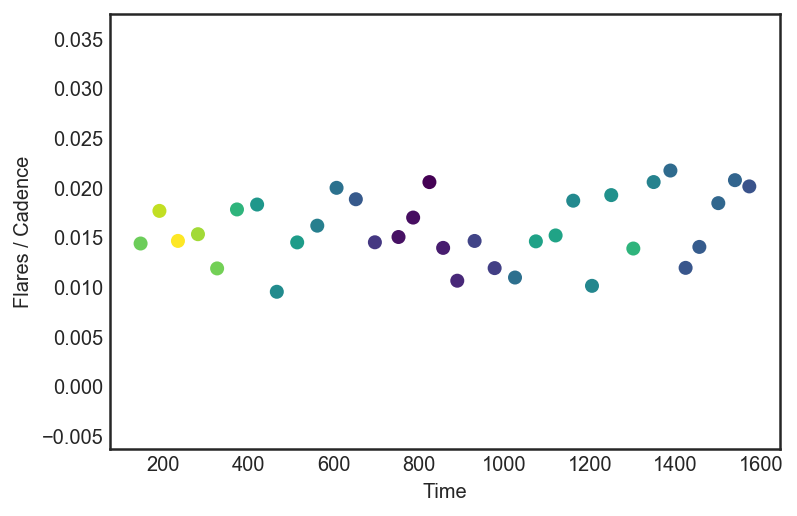

In [1190]:
plt.scatter(sec_t, sec_flares, c=sec_std, cmap='viridis')
plt.xlabel('Time')
plt.ylabel("Flares / Cadence")

In [1191]:
# all_flc = flcs[0].normalize().copy()
# [all_flc.append(flc1.normalize(), inplace=True) for flc1 in flcs[1:]]

corr_med = interp1d(sec_t, sec_med, kind='cubic', fill_value=1, bounds_error=False)(all_flc.time)
corr_std = np.polyval(np.polyfit(sec_t, sec_std, 11), all_flc.time)
#all_flc = ((all_flc - corr_med)/corr_std).plot()

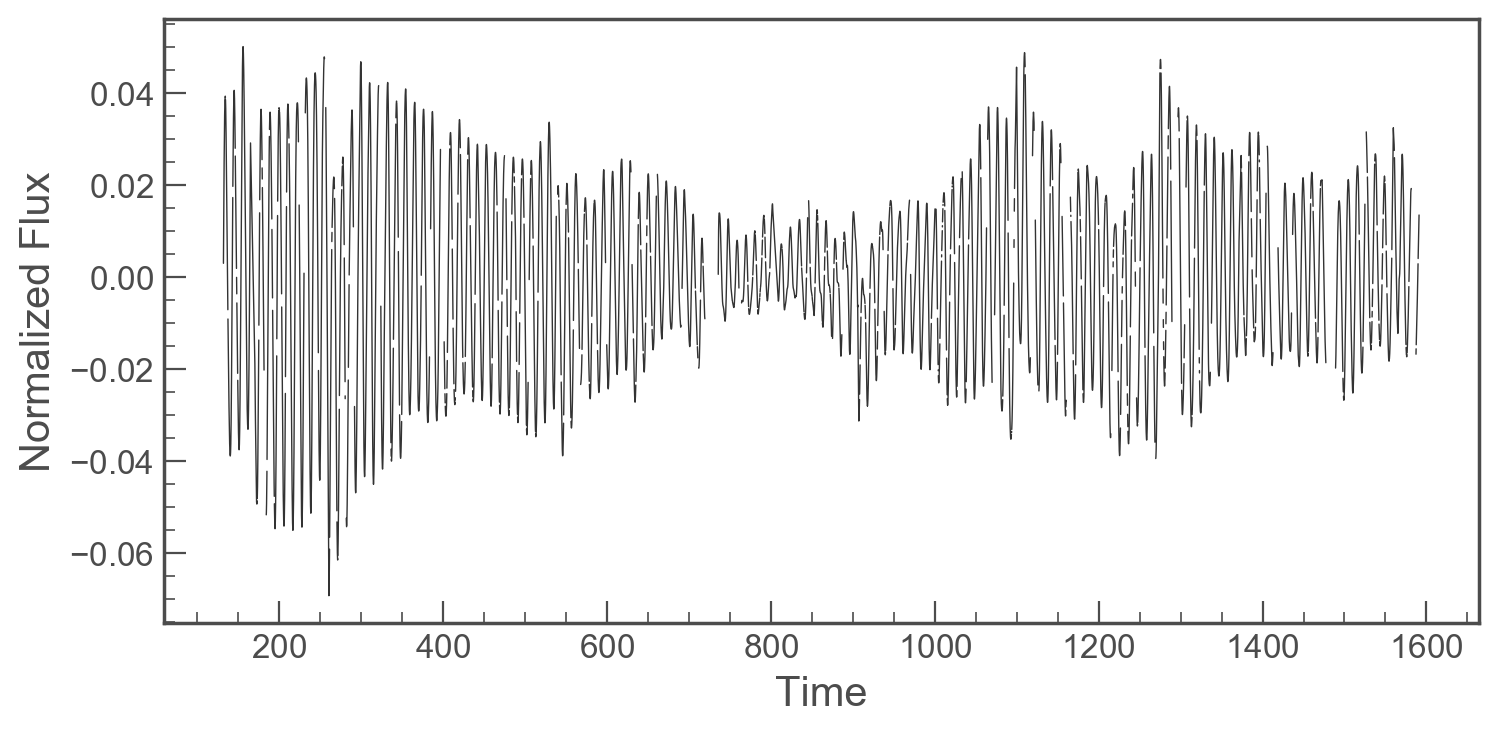

In [1192]:
(all_flc - corr_med + 1).plot()

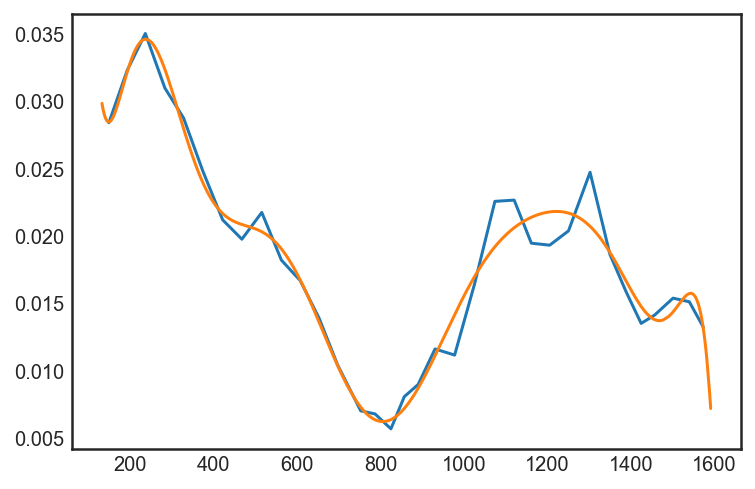

In [1193]:
plt.plot(sec_t, sec_std)
plt.plot(all_flc.time, corr_std)

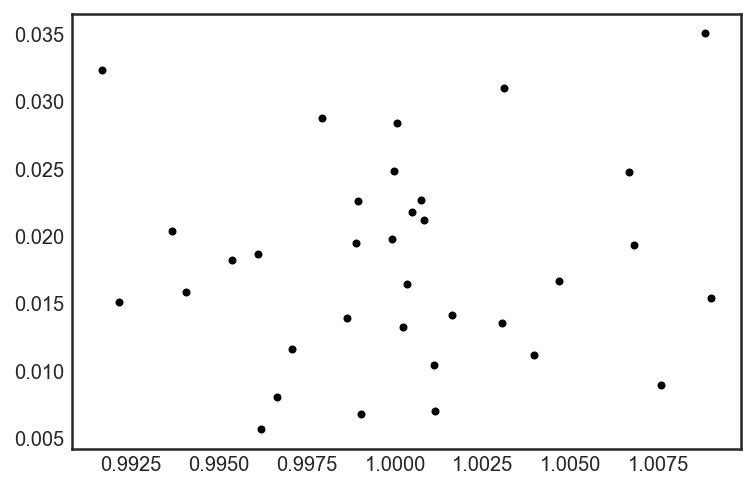

In [1194]:
plt.plot(sec_med, sec_std, 'k.')

In [1195]:
rlc = ((all_flc - corr_med + 1)/corr_std)
df, f = np.gradient(rlc.flux), rlc.flux
flare_f = all_clc.flux - 1
angle =  np.arctan2(df/np.nanstd(df), f/np.nanstd(f))*180/np.pi
radius =  np.hypot(df/df.std(), f/f.std())



(-0.2, 0.2)

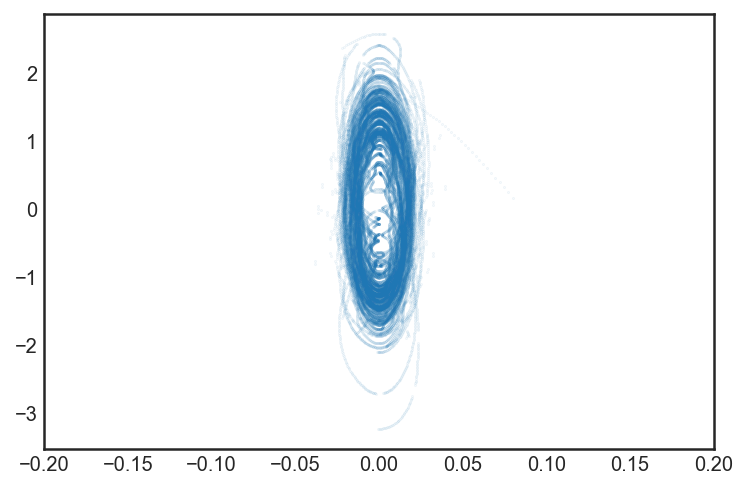

In [1196]:
plt.scatter(np.gradient(rlc.flux), rlc.flux, s=0.1, alpha=0.1)
plt.xlim(-0.2, 0.2)

/Users/ch/miniconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/ch/miniconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


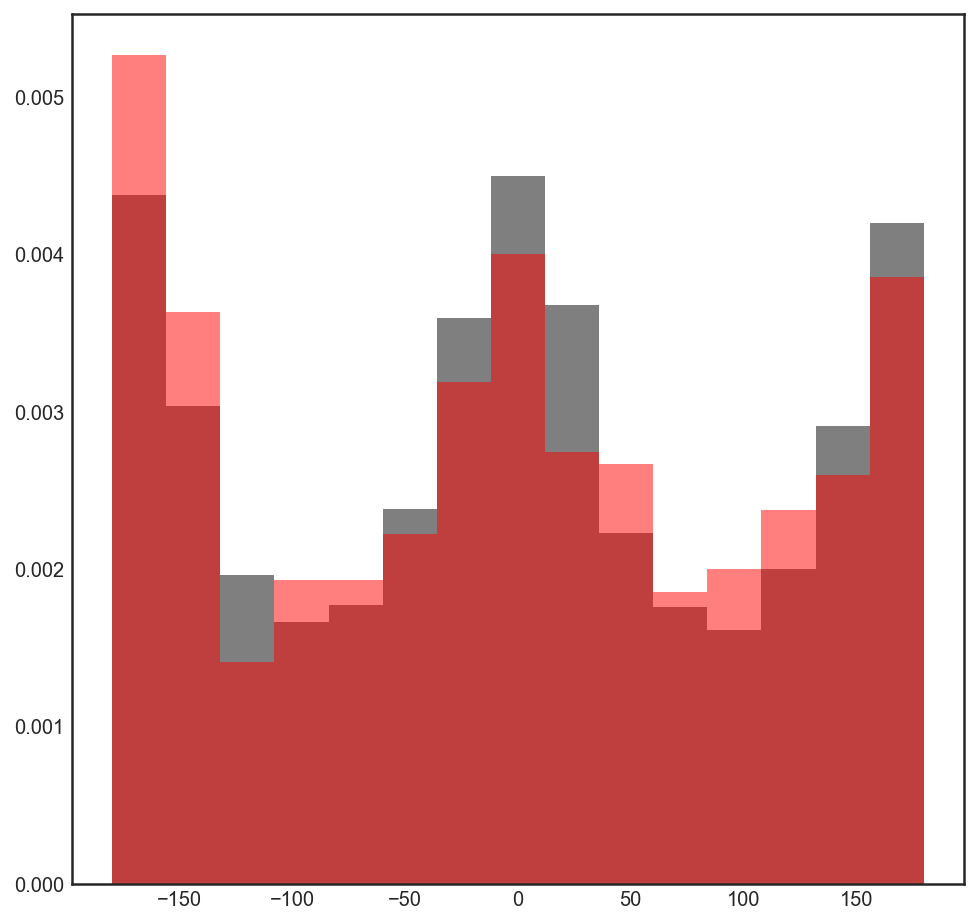

In [1197]:
plt.figure(figsize=(8, 8))
h1 = plt.hist(angle[~bad], 15, density=True, alpha=0.5, color='k');
h2 = plt.hist(angle[flares], h1[1], density=True, alpha=0.5, color='r');

(-0.2, 0.2)

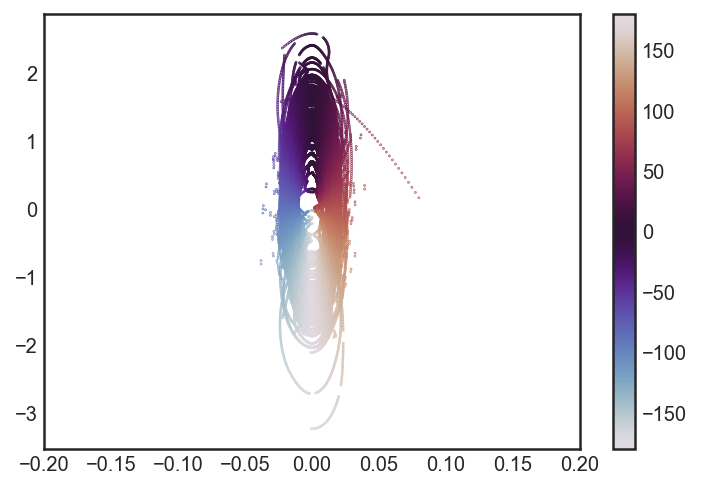

In [1198]:
plt.scatter(np.gradient(rlc.flux), rlc.flux, s=0.1, c=angle, cmap='twilight')
plt.colorbar()
plt.xlim(-0.2, 0.2)

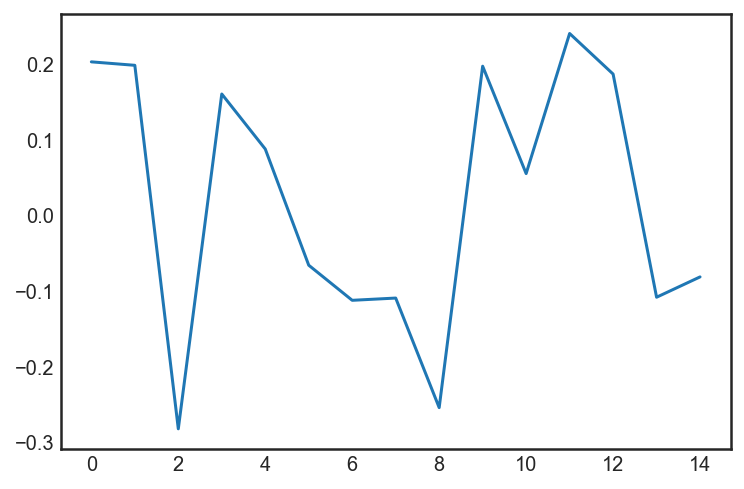

In [1199]:
plt.plot((h2[0] - h1[0])/h1[0])

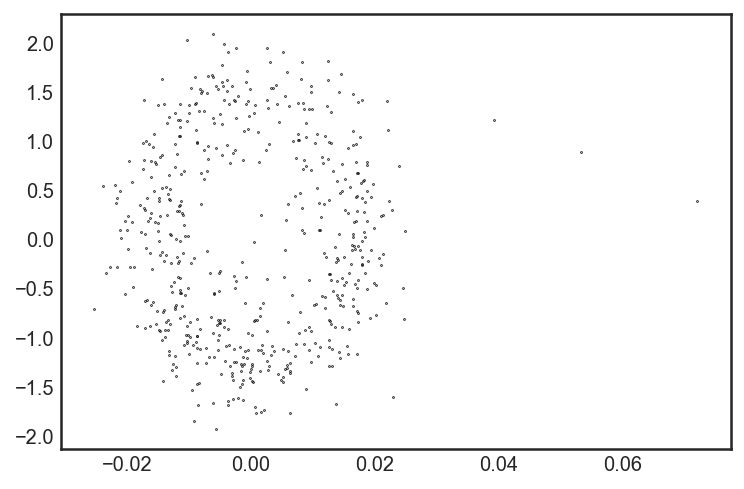

In [1200]:
plt.scatter(df[flares], f[flares], s=0.1, c='k')

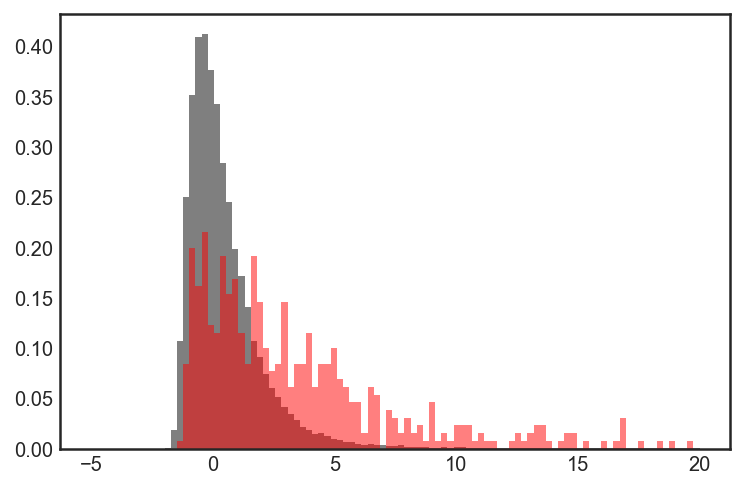

In [1201]:
plt.hist(residuals[~flares], np.linspace(-5, 20, 100), color='k', density=True, alpha=0.5);
plt.hist(residuals[flares], np.linspace(-5, 20, 100), color='r', density=True, alpha=0.5);

In [1202]:
cuts = np.where((np.append(0, np.diff(angle)) > 180))[0]
angs = np.array_split(angle, cuts)
fluxs = np.array_split(all_flc.flux - corr_med + 2, cuts)
flares_cut = np.array_split(flares, cuts)

/Users/ch/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


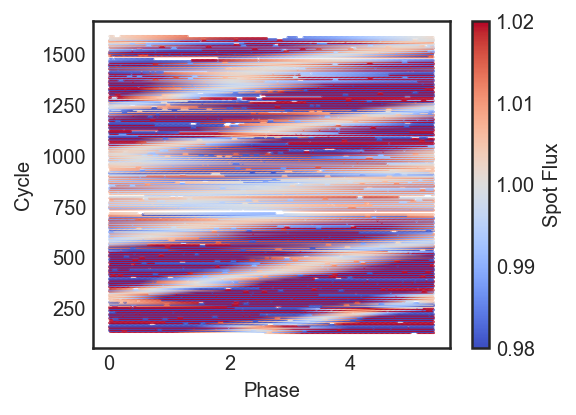

In [1203]:
plt.figure(figsize=(4, int(0.03 * len(cuts))))
plt.scatter(all_flc.time % full_period, all_flc.time - (all_flc.time % full_period), s=0.1, c=all_flc.flux  - corr_med + 2, vmin=0.98, vmax=1.02, cmap='coolwarm')

plt.xlabel('Phase')
plt.ylabel('Cycle')
cbar = plt.colorbar()
cbar.set_label('Spot Flux')

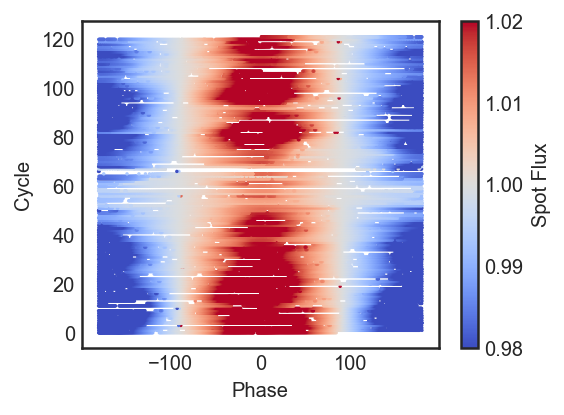

In [1204]:
angs = np.array_split(angle, cuts)
fluxs = np.array_split(all_flc.flux - corr_med + 2, cuts)

plt.figure(figsize=(4, int(0.03 * len(cuts))))

[plt.scatter(ang, np.ones(len(ang))*idx, c=flux, vmin=0.98, vmax=1.02, cmap='coolwarm', s=0.5) for idx, ang, flux in zip(range(len(angs)), angs, fluxs)];

plt.xlabel('Phase')
plt.ylabel('Cycle')
cbar = plt.colorbar()
cbar.set_label('Spot Flux')

In [1205]:
ang_all = np.asarray([ang for idx, ang in zip(range(len(angs)), angs)])
cyc_all = np.asarray([np.ones(len(ang))*idx for idx, ang in zip(range(len(angs)), angs)])

ang_flares = np.asarray([ang[mask] for idx, ang, mask in zip(range(len(angs)), angs, flares_cut)])
cyc_flares = np.asarray([np.ones(mask.sum())*idx for idx, ang, mask in zip(range(len(angs)), angs, flares_cut)])


#ang_flares, cyc_flares = np.asarray([(ang[flare_mask], np.ones(flare_mask.sum())*idx) for idx, ang, flare_mask in zip(range(len(angs)), angs, flares_cut)]).T

In [1206]:
ncyc = 5
nb = 10

k = np.isfinite(np.hstack(ang_all))
#x = np.linspace(-180, 180, 60, dtype=int)
y = np.arange(0, np.hstack(cyc_all).max(), ncyc)
x = np.linspace(-180, 180, (k.sum()/len(y))//10)
ar, X, Y = np.histogram2d(np.hstack(ang_all)[k], np.hstack(cyc_all)[k], bins=(x, y))

/Users/ch/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  import sys


In [1207]:
k = np.isfinite(np.hstack(ang_flares))
ar2 = np.histogram2d(np.hstack(ang_flares)[k], np.hstack(cyc_flares)[k], bins=(X, Y))[0]

In [1208]:
ar_e = ar**0.5/ar
ar2_e = 0
e = (ar2/ar) * (((ar_e/ar)**2 + (ar2_e/ar2)**2)**0.5)


/Users/ch/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [1209]:
res = np.copy(ar2/ar)
bad = (e/res >= 0.5) | ~np.isfinite(e)
res[bad] = np.nan

/Users/ch/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater_equal
  


Text(0, 0.5, 'Cycle')

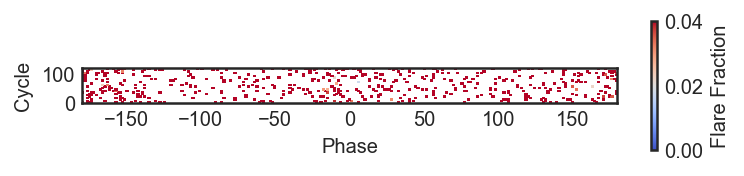

In [1210]:
plt.figure(figsize=(6, 6*2*ar.shape[1]/ar.shape[0]))
plt.pcolormesh(X, Y, res.T, vmin=0, vmax=0.04, cmap='coolwarm')
cbar = plt.colorbar()
cbar.set_label('Flare Fraction')
plt.gca().set_aspect(2*ar.shape[1]/ar.shape[0])


plt.xlabel('Phase')
plt.ylabel('Cycle')


/Users/ch/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/Users/ch/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ch/miniconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Text(0, 0.5, 'Flare Fraction [n/cadence]')

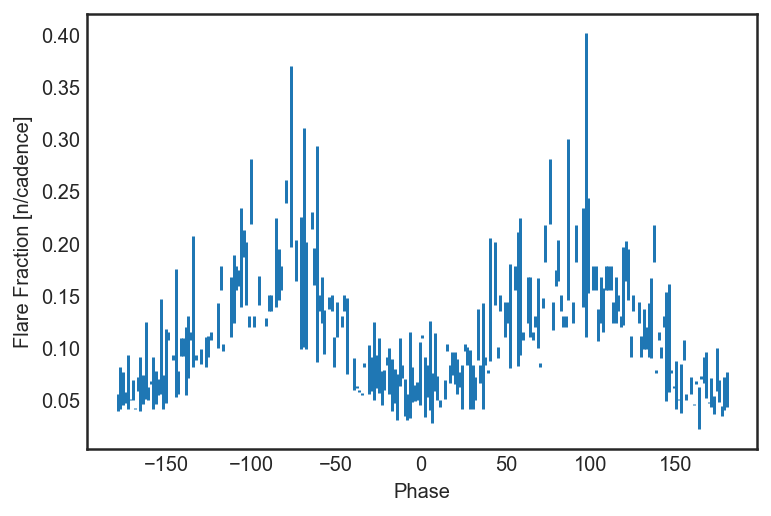

In [1211]:
weights = np.sum(~bad, axis=1)
res_summed = np.nansum(res, axis=1)/weights
e_summed1 = np.nansum(e**2, axis=1)**0.5/weights

e_summed2 = (np.nanstd(res, axis=1))
e_summed = ((e_summed1)**2 + (e_summed2**2))**0.5

plt.errorbar(x[1:], res_summed, e_summed, ls='')
plt.xlabel('Phase')
plt.ylabel('Flare Fraction [n/cadence]')

Text(0, 0.5, 'Flare Fraction [n/cadence]')

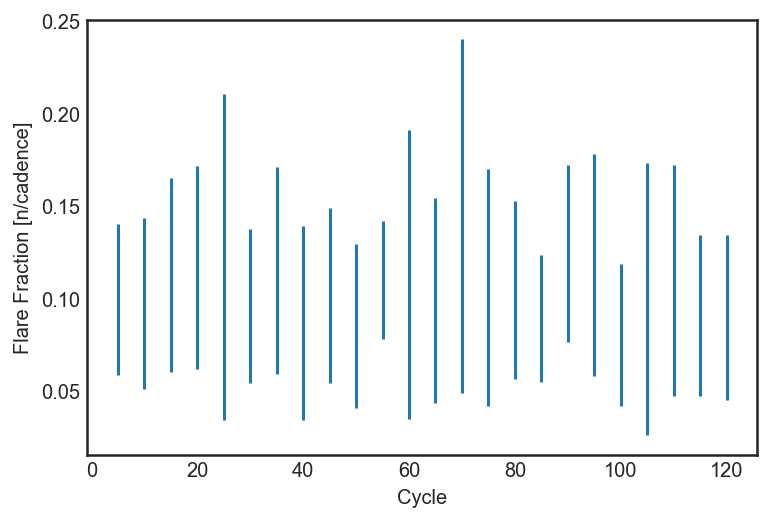

In [1212]:
weights = np.sum(~bad, axis=0)
res_summed = np.nansum(res, axis=0)/weights
e_summed1 = np.nansum(e**2, axis=0)**0.5/weights

e_summed2 = (np.nanstd(res, axis=0))
e_summed = ((e_summed1)**2 + (e_summed2**2))**0.5

plt.errorbar(y[1:], res_summed, e_summed, ls='')
plt.xlabel('Cycle')
plt.ylabel('Flare Fraction [n/cadence]')

Text(0, 0.5, 'Cycle')

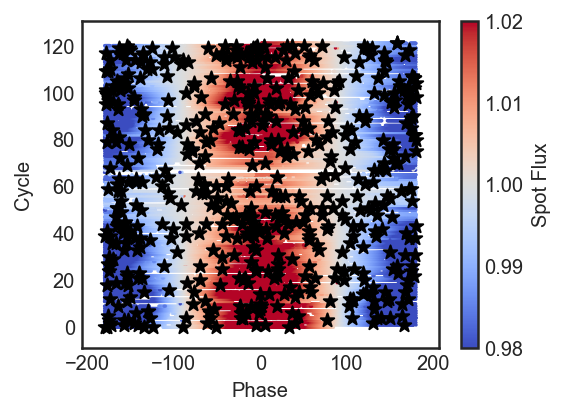

In [1213]:


plt.figure(figsize=(4, int(0.03 * len(cuts))))

[plt.scatter(ang, np.ones(len(ang))*idx, c=flux, vmin=0.98, vmax=1.02, cmap='coolwarm', s=0.5) for idx, ang, flux in zip(range(len(angs)), angs, fluxs)];
cbar = plt.colorbar()
cbar.set_label('Spot Flux')

[plt.scatter(ang[flare_mask], np.ones(flare_mask.sum())*idx, c='k', s=50, marker='*') for idx, ang, flare_mask in zip(range(len(angs)), angs, flares_cut)];



plt.xlabel('Phase')
plt.ylabel('Cycle')


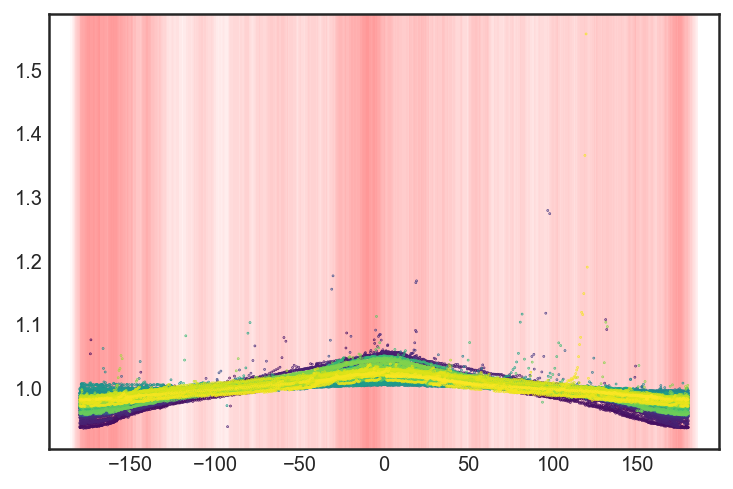

In [1214]:
plt.scatter(angle, all_lc.flux, s=0.1, c=all_lc.time, vmin=all_lc.time[0], vmax=all_lc.time[-1], cmap='viridis')
for a in angle[flares]:
    plt.axvline(a, c='red', alpha=0.01, lw=10, zorder=-1)
#plt.ylim(0.95, 1.05)